# Using pyTorch implementation

In this second part, we use pyTorch's implementation of RNNs and LSTMs. Again, as we are focusing on understanding the model and library, we will keep using the IMDB dataset. The good news is training is much faster using pyTorch's implementations.

In [1]:
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple

from datasets import load_dataset
import numpy as np
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext.vocab import vocab, Vocab, build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

## From dataset to batch inputs

You already know what to do here, it's the same as in the previous notebook.

In [2]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

Found cached dataset imdb (/home/maxenceoden/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached split indices for dataset at /home/maxenceoden/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-5f37fd0866e4f89f.arrow and /home/maxenceoden/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-dd5732a0e6ac784c.arrow


((20000, 2), (5000, 2), (25000, 2))

In [3]:
tokenizer = get_tokenizer("basic_english", language='en')
def yield_tokens(data):
    for doc in data:
        yield tokenizer(doc['text'])
vocabulary = build_vocab_from_iterator(yield_tokens(train_df), specials=["<unk>", "<pad>"], min_freq=1)
vocabulary.set_default_index(vocabulary["<unk>"])

In [4]:
def vectorize_text(
    text: str, vocabulary: Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Generate a tensor of vocabluary IDs for a given text.
    Args:
        text: the input text.
        vocabulary: a Vocab objects.
        tokenizer: a text tokenizer.
    Returns:
        A tensor of IDs (torch.long).
    """
    tokens = tokenizer(text)
    ids = vocabulary.forward(tokens)
    return torch.tensor(ids, dtype=torch.long)

In [5]:
text_pipeline = partial(vectorize_text, vocabulary=vocabulary, tokenizer=tokenizer)

In [6]:
text_pipeline("Some text I am thinking about... ragafqfa")

tensor([  56, 3167,   13,  244,  527,   50,    3,    3,    3,    0])

In [7]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [85]:
def data_generator(
    X: List[torch.tensor], y: List[int], pad_id: int, batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    X, y = shuffle(X, y)

    # Find max length
    len_max = 0
    for x in X:
        len_max = max(len_max, len(x))

    for batch in range(0, len(X), batch_size):
        batch_X = X[batch:batch + batch_size]
        batch_y = y[batch:batch + batch_size]

        batch_y = torch.tensor(batch_y)
        
        # Padding
        for vec_i in range(len(batch_X)):
            if len_max - len(batch_X[vec_i]) != 0:
                padding = torch.full((len_max - len(batch_X[vec_i]), ), pad_id)
                batch_X[vec_i] = torch.cat((padding, batch_X[vec_i]))
            else:
                batch_X[vec_i] = torch.tensor(batch_X[vec_i], dtype=torch.long)

        yield torch.stack(batch_X), batch_y

In [86]:
pad_token = "<pad>"
train_gen = lambda: data_generator(X_train, y_train, vocabulary[pad_token])
valid_gen = lambda: data_generator(X_valid, y_valid, vocabulary[pad_token])
test_gen = lambda: data_generator(X_test, y_test, vocabulary[pad_token])

## The classifier

The implementation behind shows how to use the [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) implementation provided by pyTorch to code a simple RNN.

In [87]:
class RNN(nn.Module):
    """A simple RNN module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs


        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The RNN
        self.rnn = nn.RNN(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.rnn(out, h0)
        # Getting the last value only.
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out

## Training (1 point)

**\[1 point\]** Code the training function.
* Note that we are using a function, as we will use it on several models here.
* The RNN implementation of pyTorch doesn't need to be manually looped. As commented in the `forward` function above, `out` contains the ouptut layer for all words in the sequence, and taking its last value is what we needed.

In [88]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [101]:
def train(
    model: nn.Module,
    criterion: Callable,
    optimizer: torch.optim.Optimizer,
    n_epochs: int,
    train_gen: Callable,
    valid_gen: Callable,
) -> Tuple[nn.Module, List[float], List[float]]:
    """Train a model using a batch gradient descent.
    Args:
        model: a class inheriting from nn.Module.
        criterion: a loss criterion.
        optimizer: an optimizer (e.g. Adam, RMSprop, ...).
        n_epochs: the number of training epochs.
        train_gen: a callable function returing a batch (data, labels).
        valid_gen: a callable function returing a batch (data, labels).
    Returns:
        A tuple:[best_model (by validation loss), training losses, validation losses].
    """
    best_model = None
    best_valid_loss = np.inf
    train_losses = []
    valid_losses = []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        train_loss = 0.0
        iter = 0
        for X_batch, y_batch in train_gen():
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).float()

            optimizer.zero_grad()

            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            iter += 1

        train_loss /= iter
        train_losses.append(train_loss)

        model.eval()
        valid_loss = 0.0
        iter = 0
        with torch.no_grad():
            for X_batch, y_batch in valid_gen():
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device).float()

                y_pred = model(X_batch).squeeze()
                loss = criterion(y_pred, y_batch)

                valid_loss += loss.item()
                iter += 1

        valid_loss /= iter
        valid_losses.append(valid_loss)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = model

        print(f"Epoch {epoch + 1}: train loss {train_loss:.4f} | valid loss {valid_loss:.4f}")

    return best_model, train_losses, valid_losses

In [102]:
model = RNN(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [103]:
best_model, train_losses, valid_losses = train(model, criterion, optimizer, 20, train_gen, valid_gen)

  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_83318/3587748168.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_X[vec_i] = torch.tensor(batch_X[vec_i], dtype=torch.long)


Epoch 1: train loss 0.6802 | valid loss 0.6766
Epoch 2: train loss 0.6423 | valid loss 0.6627
Epoch 3: train loss 0.6246 | valid loss 0.6356
Epoch 4: train loss 0.5895 | valid loss 0.6519
Epoch 5: train loss 0.5688 | valid loss 0.6592
Epoch 6: train loss 0.5915 | valid loss 0.6461
Epoch 7: train loss 0.5516 | valid loss 0.6057
Epoch 8: train loss 0.5223 | valid loss 0.6161
Epoch 9: train loss 0.4797 | valid loss 0.5776
Epoch 10: train loss 0.4810 | valid loss 0.5906
Epoch 11: train loss 0.4021 | valid loss 0.5551
Epoch 12: train loss 0.4055 | valid loss 0.5713
Epoch 13: train loss 0.3472 | valid loss 0.5556
Epoch 14: train loss 0.3174 | valid loss 0.5328
Epoch 15: train loss 0.3472 | valid loss 0.5847
Epoch 16: train loss 0.3007 | valid loss 0.5734
Epoch 17: train loss 0.3027 | valid loss 0.5692
Epoch 18: train loss 0.3188 | valid loss 0.6197
Epoch 19: train loss 0.2679 | valid loss 0.6286
Epoch 20: train loss 0.2214 | valid loss 0.6093


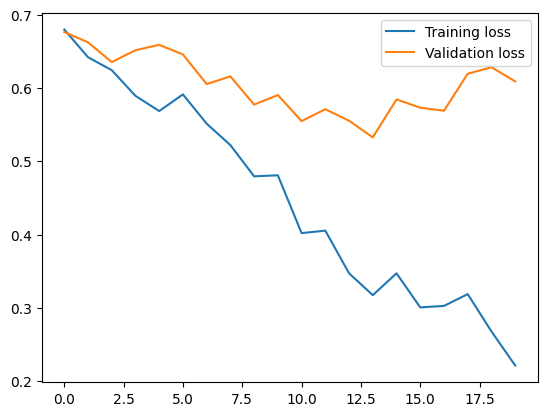

In [104]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

## Do the following (5 points)
* **\[1 point\]** Add an accuracy function and report the accuracy of the training, validation, and test set.
* **\[2 points\]** Create an LSTM class which uses an LSTM instead of an RNN. Compare its results with the RNN.
  * Look at the [LSTM documentation of pyTorch](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).
* **\[1 point\]** Implement a function which takes any text and returns the model's prediction.
    * The function should have a string as input and return a class (0 or 1) and its confidence (between 0 and 1).
* **\[Bonus\]** Create a bidirectional LSTM (BiLSTM) class to classify your sentences. Report the accuracy on the training and test data.
    * **Beware of the behaviour of the output layer.** For a bidirectional LSTM, the output layer concatenates the forward and backward vector of each token. But we need to use the forward output of the last token, and the backward output of the first token, as input to our output layer.
* **\[1 point\]** With your best classifier, look at two wrongly classified examples on the test set. Try explaining why the model was wrong.
* **\[Bonus\]** Try finding better hyperparameters (dimensions, number of layers, ...). Document your experiments and results.

In [105]:
def accuracy(model: nn.Module, gen: Callable) -> float:
    """Compute the accuracy of a model.
    Args:
        model: a class inheriting from nn.Module.
        gen: a callable function returing a batch (data, labels).
    Returns:
        The accuracy of the model.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in gen():
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).float()

            y_pred = model(X_batch).squeeze()
            y_pred = (y_pred > 0.5).float()

            correct += (y_pred == y_batch).sum().item()
            total += y_batch.size(0)

    return correct / total

In [106]:
print(f"Train accuracy: {accuracy(best_model, train_gen):.4f}")
print(f"Valid accuracy: {accuracy(best_model, valid_gen):.4f}")
print(f"Test accuracy: {accuracy(best_model, test_gen):.4f}")

/tmp/ipykernel_83318/3587748168.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_X[vec_i] = torch.tensor(batch_X[vec_i], dtype=torch.long)


Train accuracy: 0.9286
Valid accuracy: 0.7732
Test accuracy: 0.7682


Create an LSTM class which uses an LSTM instead of an RNN. Compare its results with the RNN.

In [107]:
class LSTM(nn.Module):
    """A simple LSTM module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs


        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The LSTM
        self.lstm = nn.LSTM(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        out, _ = self.lstm(out, (h0, c0))
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out

In [108]:
n_epochs = 20
model = LSTM(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [109]:
lstm_best_model, lstm_train_losses, lstm_valid_losses = train(model, criterion, optimizer, n_epochs, train_gen, valid_gen)

  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_83318/3587748168.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_X[vec_i] = torch.tensor(batch_X[vec_i], dtype=torch.long)


Epoch 1: train loss 0.6682 | valid loss 0.6367
Epoch 2: train loss 0.5769 | valid loss 0.5459
Epoch 3: train loss 0.4006 | valid loss 0.3961
Epoch 4: train loss 0.2780 | valid loss 0.3629
Epoch 5: train loss 0.2325 | valid loss 0.3461
Epoch 6: train loss 0.1682 | valid loss 0.3778
Epoch 7: train loss 0.1272 | valid loss 0.3685
Epoch 8: train loss 0.0932 | valid loss 0.4255
Epoch 9: train loss 0.0676 | valid loss 0.5197
Epoch 10: train loss 0.0518 | valid loss 0.5435
Epoch 11: train loss 0.0389 | valid loss 0.5209
Epoch 12: train loss 0.0318 | valid loss 0.5919
Epoch 13: train loss 0.0275 | valid loss 0.5530
Epoch 14: train loss 0.0203 | valid loss 0.6347
Epoch 15: train loss 0.0196 | valid loss 0.6921
Epoch 16: train loss 0.0167 | valid loss 0.6333
Epoch 17: train loss 0.0125 | valid loss 0.6432
Epoch 18: train loss 0.0083 | valid loss 0.7222
Epoch 19: train loss 0.0063 | valid loss 0.7030
Epoch 20: train loss 0.0106 | valid loss 0.6552


Implement a function which takes any text and returns the model's prediction.
* The function should have a string as input and return a class (0 or 1) and its confidence (between 0 and 1).

In [120]:
def predict(model: nn.Module, text: str) -> Tuple[int, float]:
    """Predict the sentiment of a text.
    Args:
        model: a class inheriting from nn.Module.
        text: the text to predict.
    Returns:
        A tuple (class, confidence).
    """
    model.eval()
    with torch.no_grad():
        X = text_pipeline(text)
        X = torch.tensor(X, dtype=torch.long).to(device)
        X = X.unsqueeze(0)
        y_pred = model(X).squeeze()
        y_pred = torch.sigmoid(y_pred)
        pred = y_pred.item()
        if pred > 0.5:
            return 1, pred
        return 0, 1 - pred

In [122]:
predict(lstm_best_model, "This movie is great!")

/tmp/ipykernel_83318/2006920908.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.long).to(device)


(1, 0.9975764155387878)